In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format
import mc_helper

lsb = 1.06 nA
max error (INL) = 1.14 µA = 1079.042 lsb
max difference (DNL) = 433.24 A = 433.242 lsb



/home/madvlsi/dev/git/7-bit-D-A-converter-MP4-MADVLSI/schematics/simulations/mc_helper.py:13: RuntimeWarning: divide by zero encountered in log10
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)
/home/madvlsi/dev/git/7-bit-D-A-converter-MP4-MADVLSI/schematics/simulations/mc_helper.py:13: RuntimeWarning: invalid value encountered in scalar remainder
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)


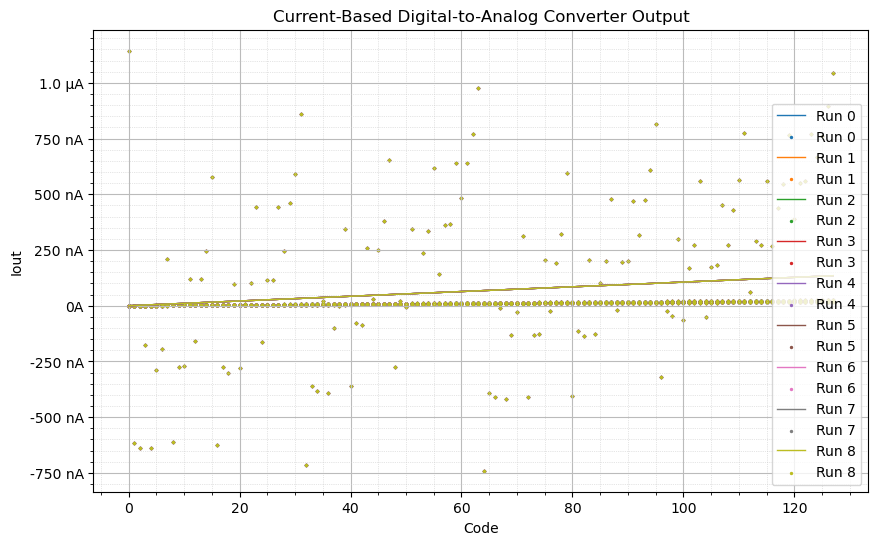

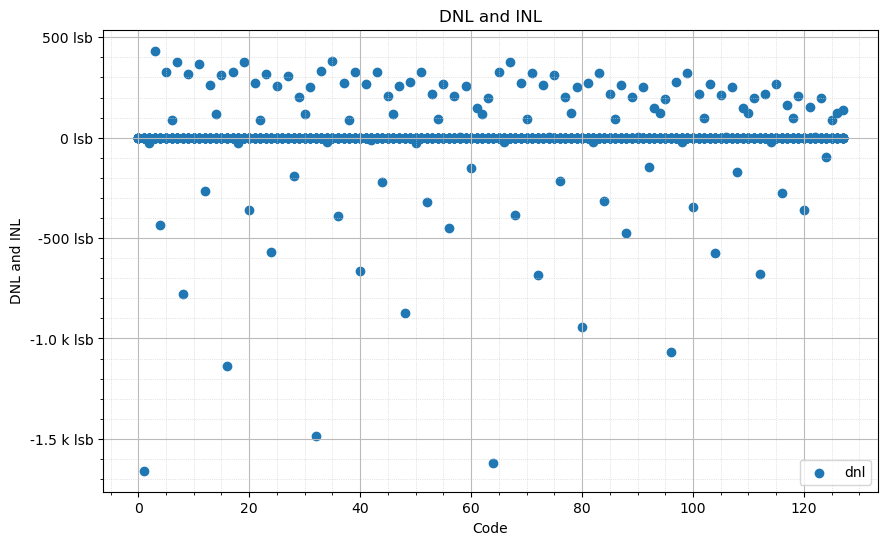

In [39]:
n_bits = 7
n_codes = 2 ** n_bits
mc_simulations = []
# results_dir = "ieee_DAC/simulation_results/"
results_dir = "ieee_DAC/dac_with_external_bias_gen/test_6"

for filename in os.listdir(results_dir):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print("Raw dataframe:")
    # print(df.head(3))
    # print()

    df["code"] = df["v0"] * 0 # init column to all 0s
    for bit in range(n_bits):
        df["code"] = df["code"] + (df[f"v{bit}"] < .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
        df.drop(f"v{bit}", axis = "columns", inplace = True)
    df.rename({"i(viout)": "Iout"}, axis = "columns", inplace = True)

    df.sort_values("code", inplace = True)
    df["diff"] = np.diff(df["Iout"], prepend = 0)
    mc_simulations.append(df)

tdf = (pd.concat(mc_simulations)).sort_values("code")
# print("Combined dataframe:")
# print(tdf.head(3))
# print()

plt.figure(figsize = (10, 6))
mc_helper.axes_labels("Code", "", "Iout", "A", "Current-Based Digital-to-Analog Converter Output")
mc_helper.make_grids()

Iout_for_max_code = np.mean(tdf["Iout"][tdf["code"] == max(tdf["code"])])
lsb = Iout_for_max_code / (n_codes - 1)
tdf["Iout_ideal"] = lsb * tdf["code"]
tdf["Iout_error"] = tdf["Iout"] - tdf["Iout_ideal"]
max_error = max(tdf["Iout_error"])
tdf["inl"] = tdf["Iout_error"] / lsb
max_inl = max(tdf["inl"])
print(f"lsb = {si_format(lsb, precision = 2)}A")
print(f"max error (INL) = {si_format(max_inl * lsb, precision = 2)}A = {np.round(max_inl, 3)} lsb")

tdf["dnl"] = tdf["diff"] / lsb - 1
tdf["dnl"][tdf["code"] == 0] = 0
max_dnl = max(tdf["dnl"])
print(f"max difference (DNL) = {si_format(max_dnl, precision = 2)}A = {np.round(max_dnl, 3)} lsb")
print()

# print("Final dataframe:")
# print(tdf.head(3))
# print()

for i, df_simulation in enumerate(mc_simulations):
    plt.plot(np.array(tdf["code"]), np.array(tdf["Iout_ideal"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(tdf["code"]), np.array(tdf["Iout"]), s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure(figsize = (10, 6))
mc_helper.axes_labels("Code", "", "DNL and INL", " lsb", "DNL and INL")
mc_helper.make_grids()

plt.scatter(tdf["code"], tdf["dnl"], label = "dnl")
# plt.scatter(tdf["code"], tdf["inl"], label = "inl")
plt.legend(loc = "lower right")